# Notebook de modelagem e avaliação 

## Importação das bibliotecas

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb


In [2]:
# Configurar paleta de cores e estilo

# Matplotlib
mpl.rcParams["figure.figsize"] = (20, 7)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

# Seaborn
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

## Aquisição dos dados

In [3]:
input_path = '../data/processed/dados_historicos_ibovespa_2015-2025_processed.csv'

df = pd.read_csv(input_path, index_col='ds', parse_dates=['ds'])
df.tail()

,close,open,high,low,volume,daily_return,return_lag_1,return_lag_2,return_lag_3,return_lag_4,...,close_lag7,sma_21,ema_50,rsi_14,atr_14,obv,day_of_week,day_of_month,month,year
ds,,,,,,,,,,,,,,,,,,,,,
2025-06-12,137800,137127,137931,136175,7.120000e+09,0.0049,0.0051,0.0054,-0.0030,-0.0010,...,137546.0,137814.619048,134894.977670,56.429439,1746.368879,1.365133e+11,3,12,6,2025
2025-06-13,137213,137800,137800,136586,8.630000e+09,-0.0043,0.0049,0.0051,0.0054,-0.0030,...,137002.0,137713.619048,134985.880507,53.149650,1708.342531,1.278833e+11,4,13,6,2025
2025-06-16,139256,137212,139988,137212,7.620000e+09,0.0149,-0.0043,0.0049,0.0051,0.0054,...,136236.0,137716.904762,135153.336173,61.530240,1784.603778,1.355033e+11,0,16,6,2025
2025-06-17,138840,139256,139497,138293,8.380000e+09,-0.0030,0.0149,-0.0043,0.0049,0.0051,...,136102.0,137679.000000,135297.911225,59.207770,1743.132080,1.271233e+11,1,17,6,2025
2025-06-18,138717,138844,139161,138443,8.320000e+09,-0.0009,-0.0030,0.0149,-0.0043,0.0049,...,135699.0,137612.666667,135431.993138,58.504620,1669.908360,1.188033e+11,2,18,6,2025


## Pré-processamento dos dados

Primeiro, vamos criar a **variável alvo** com horizonte de 1 dia para que o modelo de classificação consiga prever se o fechamento de amanhã será maior que o de hoje.

* `1` para dias de **Alta**
* `0` para dias de **Baixa**

In [4]:
# criando uma coluna de direção (baixa = 0 ou alta = 1)
target_values = (df['close'].shift(-1) > df['close']).astype(int)
df.insert(0, 'target', target_values)

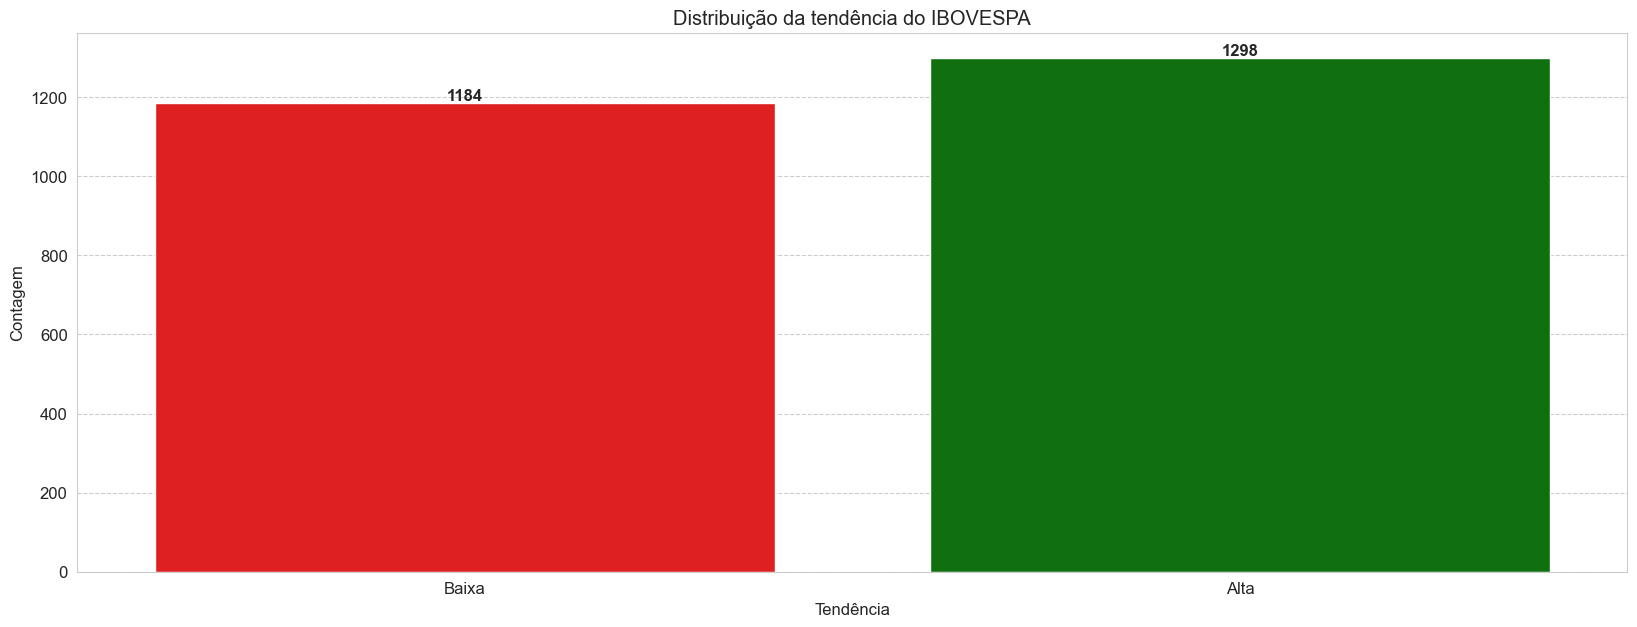

In [5]:
# Paleta
palette_green_red = {0: 'red', 1: 'green'}

# Gráfico de qtd de dias com tendência alta ou baixa
ax = sns.countplot(data=df, x='target', hue='target', palette=palette_green_red, legend=False)

# Título e rótulos dos eixos
plt.title('Distribuição da tendência do IBOVESPA')
plt.xlabel('Tendência')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Baixa', 'Alta'])

# Adiciona os valores nas barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                  (p.get_x() + p.get_width() / 2, height),
                  ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

In [6]:
# Porcentagem da distribuição da tendência
df['target'].value_counts(normalize=True)

target
1    0.522965
0    0.477035
Name: proportion, dtype: float64

Após a análise da distribuição da variável alvo, verificamos que o dataset é naturalmente balanceado. Portanto, a aplicação de técnicas de reamostragem como *oversampling* ou *undersampling* não se faz necessária.

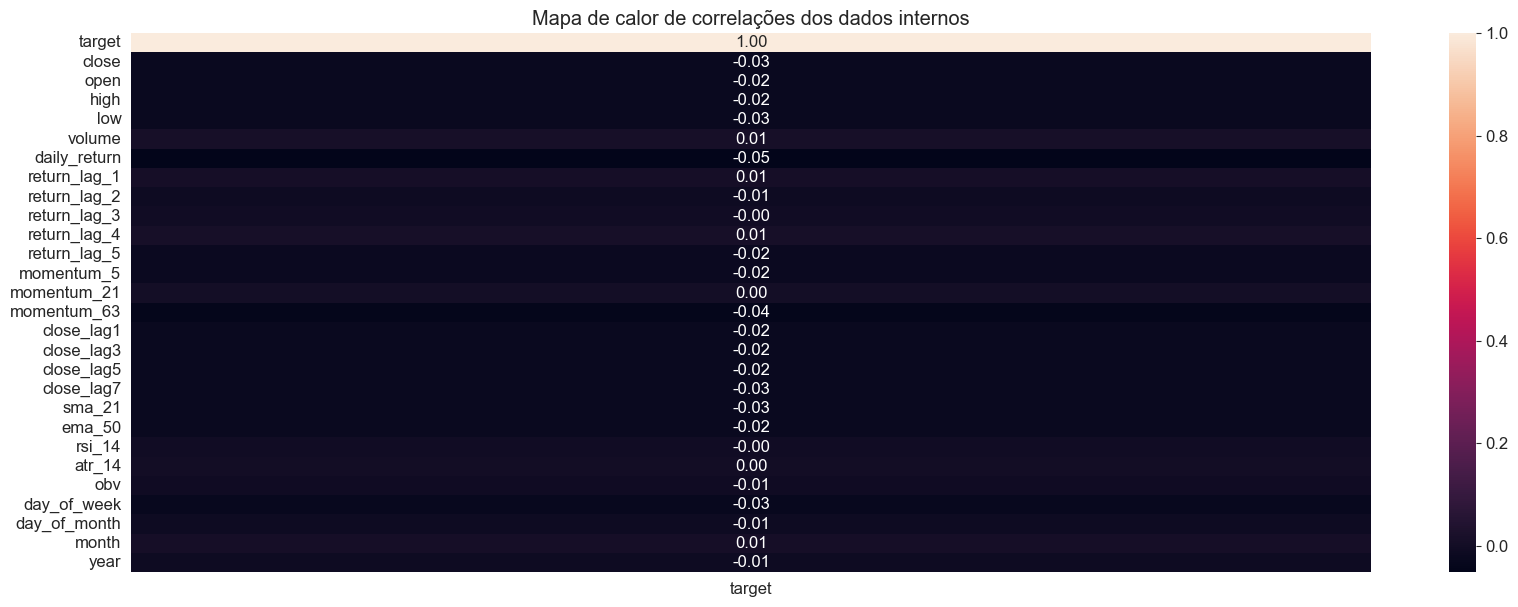

In [7]:
corr = df.corr(numeric_only=True)
target_corr = corr[['target']]


sns.heatmap(target_corr, annot=True, fmt='.2f')
plt.title('Mapa de calor de correlações dos dados internos')
plt.show()

Há uma correlação quase neutra entre a variável alvo e a maioria das variáveis.

## Construção do modelo de classificação

In [8]:
df['target']

ds
2015-06-17    1
2015-06-18    0
2015-06-19    1
2015-06-22    0
2015-06-23    1
             ..
2025-06-12    0
2025-06-13    1
2025-06-16    0
2025-06-17    0
2025-06-18    0
Name: target, Length: 2482, dtype: int64

In [ ]:
# Blocos de testes
remove_features = ['open', 'high', 'low', 'close', 'volume', 'target', 'ema_50', 'obv']

remove_features_1 = ['open', 'high', 'low', 'close', 'volume', 'target', 'ema_50', 'obv', 
                     'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_5',
                     'momentum_21', 'momentum_63', 'sma_21', 'rsi_14', 'atr_14', 'day_of_week',
                     'day_of_month', 'month', 'year']

remove_features_2 = ['open', 'high', 'low', 'close', 'volume', 'target', 'ema_50', 'obv',
                     'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_5']

'''['daily_return', 'return_lag_1', 'return_lag_2', 'return_lag_5',
       'momentum_5', 'momentum_63', 'sma_21', 'atr_14', 'rsi_14', 'china_return_lag1',
       'eua_return_lag1', 'europe_return_lag1', 'day_of_week', 'day_of_month']'''

"['daily_return', 'return_lag_1', 'return_lag_2', 'return_lag_5',\n       'momentum_5', 'momentum_63', 'sma_21', 'atr_14', 'rsi_14', 'china_return_lag1',\n       'eua_return_lag1', 'europe_return_lag1', 'day_of_week', 'day_of_month']"

In [37]:
# definindo variáveis preditoras e variável alvo

X = df.drop(columns=remove_features)
y = df['target']


In [38]:
X.columns

Index(['daily_return', 'return_lag_1', 'return_lag_2', 'return_lag_3',
       'return_lag_4', 'return_lag_5', 'momentum_5', 'momentum_21',
       'momentum_63', 'close_lag1', 'close_lag3', 'close_lag5', 'close_lag7',
       'sma_21', 'rsi_14', 'atr_14', 'day_of_week', 'day_of_month', 'month',
       'year'],
      dtype='object')

In [39]:
# divisão entre treino e teste (30 dias de pregão, conforme requisito) de forma cronológica (sem aleatoriedade)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

print(f"Tamanho do treino: {len(X_train)} amostras")
print(f"Tamanho do teste: {len(X_test)} amostras")

Tamanho do treino: 2452 amostras
Tamanho do teste: 30 amostras


Diferente dos demais modelos utilizados, a Regressão Logística (que será o modelo de baseline) e o SVM são sensíveis à escala das features. Por isso, vamos padronizar os dados para esses dois modelos. Como dados financeiros podem ter eventos extremos em épocas de crise, escolhemos o método de escalonamento do `StandardScaler()`, pois é mais robusto a outliers.

In [40]:
# definindo modelos de classificação
seed = 42
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=seed, n_jobs=-1))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(random_state=seed, C=1))
    ]),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=2, random_state=seed),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=seed, n_jobs=-1)
}

In [41]:
# treinando os modelos
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)

print("Todos os modelos foram treinados!")

Treinando Logistic Regression...
Treinando SVM...
Treinando Decision Tree...
Treinando Random Forest...
Treinando XGBoost...
Todos os modelos foram treinados!


## Avaliação do modelo

In [ ]:
# comparando o desempenho dos modelos
performance = pd.DataFrame(
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    performance.loc[performance.shape[0]] = {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }
performance.set_index("Model", inplace=True)
performance = performance.map(lambda x: f"{100 * x:2.2f} %")
performance.sort_values("F1-Score", ascending=False, inplace=True)
performance

,Accuracy,Precision,Recall,F1-Score
Model,,,,
SVM,63.33 %,63.38 %,63.33 %,62.70 %
XGBoost,60.00 %,65.77 %,60.00 %,53.65 %
Logistic Regression,53.33 %,55.33 %,53.33 %,52.07 %
Random Forest,50.00 %,47.83 %,50.00 %,46.15 %
Decision Tree,53.33 %,28.44 %,53.33 %,37.10 %


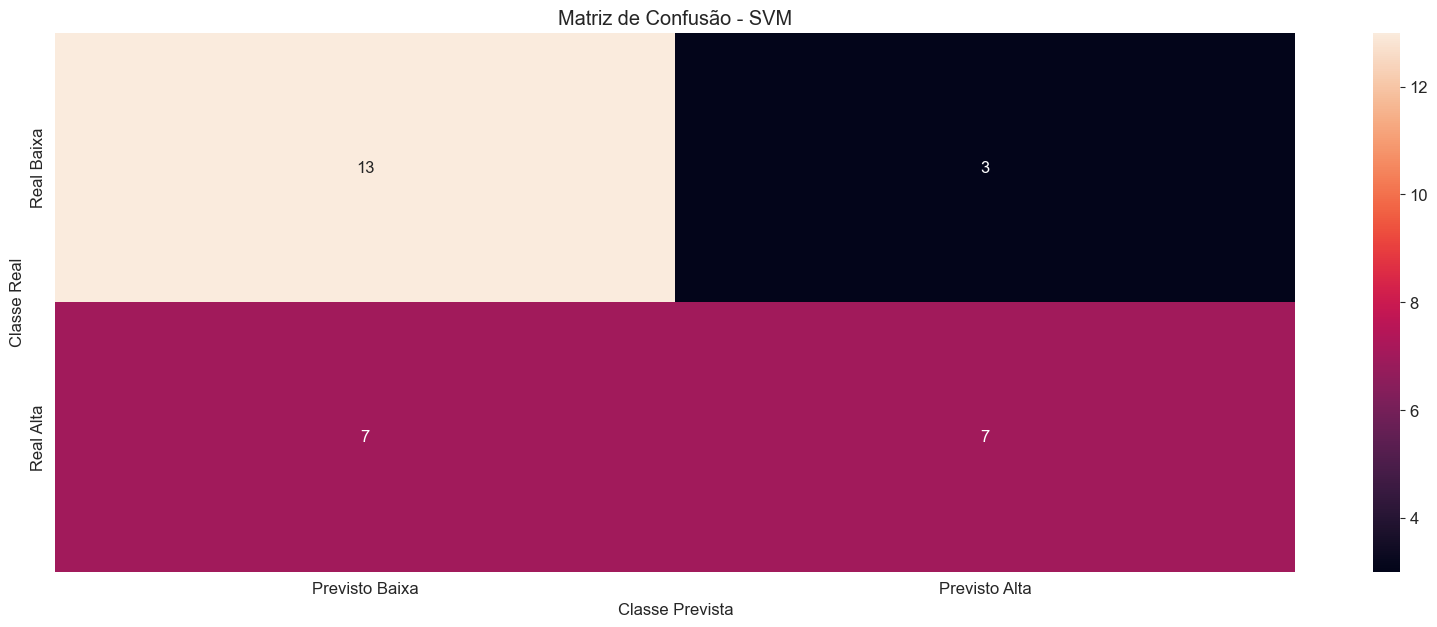

In [ ]:
# matriz de confusão para o melhor modelo
best_model_name = performance.idxmax().iloc[0]
best_model = models[best_model_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))

sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['Previsto Baixa', 'Previsto Alta'], 
            yticklabels=['Real Baixa', 'Real Alta'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

O modelo acerta muito bem a classe "Baixa", mas tem dificuldade de prever a classe "Alta".

## Seleção das features

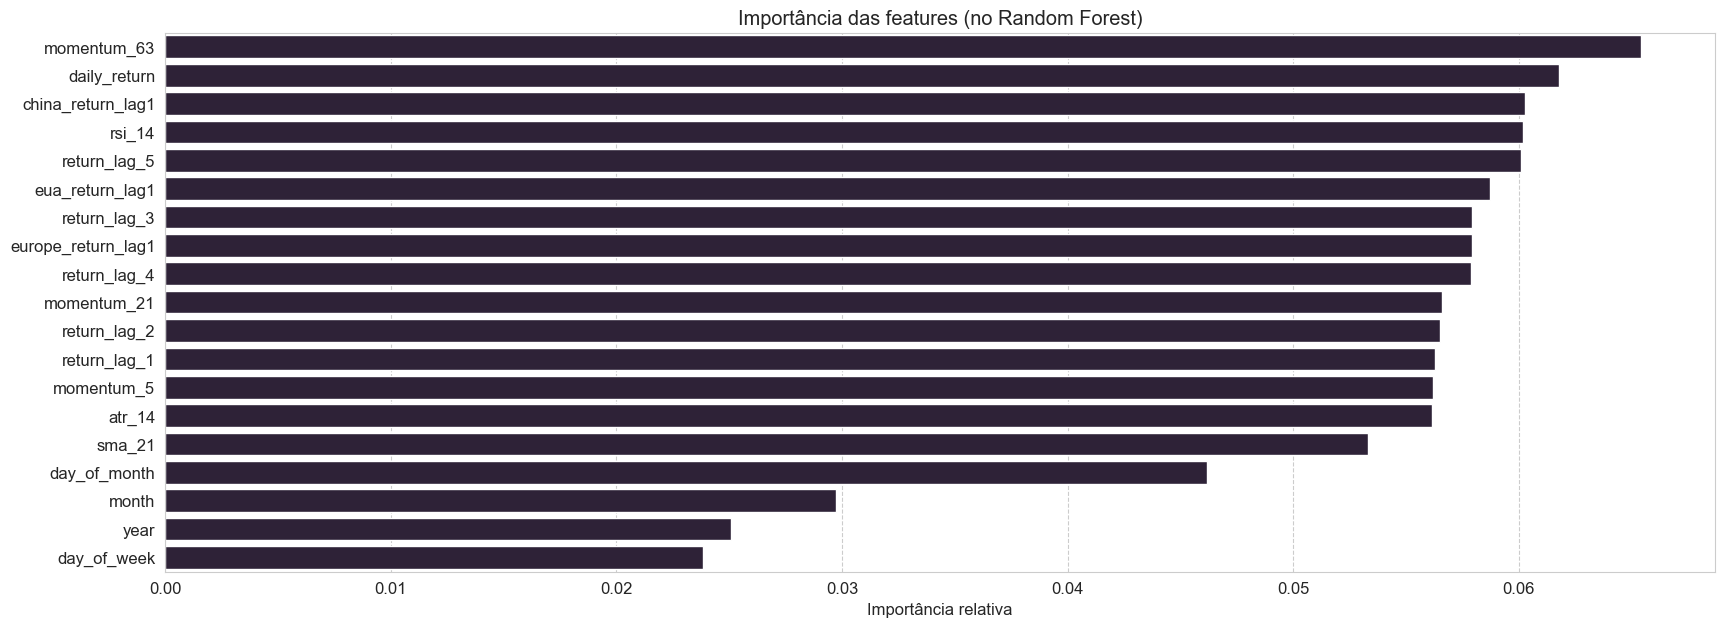

In [ ]:
feature_importances = pd.Series(models['Random Forest'].feature_importances_, index=X_train.columns).sort_values(ascending=False).reset_index(name='importancia')

# plotando as features em ordem de importância para a previsão do modelo
sns.barplot(data=feature_importances, x='importancia', y='index')
plt.title('Importância das features (no Random Forest)')
plt.ylabel('')
plt.xlabel('Importância relativa')
plt.show()

In [ ]:
# filtrar as features que atendem ao critério
importance_threshold = 0.045
best_features = feature_importances[feature_importances['importancia'] > importance_threshold]['index'].tolist()

print(f"Número de features original: {len(feature_importances)}")
print(f"Número de features após seleção com limiar de {importance_threshold}: {len(best_features)}")
print("\nFeatures que serão mantidas para a otimização:")
print(list(best_features))

Número de features original: 19
Número de features após seleção com limiar de 0.045: 16

Features que serão mantidas para a otimização:
['momentum_63', 'daily_return', 'china_return_lag1', 'rsi_14', 'return_lag_5', 'eua_return_lag1', 'return_lag_3', 'europe_return_lag1', 'return_lag_4', 'momentum_21', 'return_lag_2', 'return_lag_1', 'momentum_5', 'atr_14', 'sma_21', 'day_of_month']


In [ ]:
# dividir treino e testar novamente com as novas features
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]

## Ajuste de hiperparâmetros com validação cruzada

A validação cruzada ajuda a garantir que o modelo não está sobreajustado aos dados de treinamento e terá um bom desempenho em dados novos. 

In [ ]:
# hiperparâmetros que iremos testar
# usamos 'model__parametro' por causa do pipeline
param_grid_svm = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': ['scale', 'auto', 0.1, 1],
    'model__kernel': ['rbf']
}

# validação cruzada para dados de séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# configuração do GridSearchCV
grid_search_svm = GridSearchCV(
    estimator=models['SVM'],
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1
)

grid_search_svm.fit(X_train_selected, y_train)

# análise dos resultados
print("Melhores parâmetros para o SVM: ", grid_search_svm.best_params_)
print("Melhor acurácia na validação cruzada do SVM: {:.2%}".format(grid_search_svm.best_score_))

Melhores parâmetros para o SVM:  {'model__C': 10, 'model__gamma': 1, 'model__kernel': 'rbf'}
Melhor acurácia na validação cruzada do SVM: 52.99%


In [ ]:
# melhor SVM no conjunto de teste
best_svm = grid_search_svm.best_estimator_
pred_test_svm = best_svm.predict(X_test_selected)

print("Relatório de classificação do SVM:\n")
print(classification_report(y_test, pred_test_svm))

Relatório de classificação do SVM:

              precision    recall  f1-score   support

           0       0.60      0.56      0.58        16
           1       0.53      0.57      0.55        14

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.57        30
weighted avg       0.57      0.57      0.57        30



## Conclusão

Modelos mais simples (como SVM) superaram os complexos (Random Forest, XGBoost) que sofreram de overfitting.